# Modelos Baseline

En este notebook se implementaran los modelos baseline del proyecto y se guardaran las métricas con el mismo dataset que se utilizará para el modelo principal para hacer bentchmarking

## Lectura de los datos

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from utils.recomender_metrics import prepare_ground_truth, evaluate_recommendations, print_evaluation_results
from collections import defaultdict
from utils.UKnn import UserKNN, calculate_mae, calculate_rmse

In [2]:
data_folder = '../data/raw/ml-100k/'

In [3]:
r_cols = ['user_id', 'item_id', 'rating', 'timestamp']

# Read the training and testing sets
train_df = pd.read_csv(f'{data_folder}u1.base', sep='\t', names=r_cols, encoding='latin-1')
test_df = pd.read_csv(f'{data_folder}u1.test', sep='\t', names=r_cols, encoding='latin-1')

train_df['rating'] = train_df['rating'].astype(int)
test_df['rating'] = test_df['rating'].astype(int)

train_df['rating'] = pd.to_numeric(train_df['rating'], errors='coerce').astype('Int64')
test_df['rating'] = pd.to_numeric(test_df['rating'], errors='coerce').astype('Int64')

print("Training Data Head:")
print(train_df.head())

Training Data Head:
   user_id  item_id  rating  timestamp
0        1        1       5  874965758
1        1        2       3  876893171
2        1        3       4  878542960
3        1        4       3  876893119
4        1        5       3  889751712


In [4]:
i_cols = [
    'item_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
    'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy',
    'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
    'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
]

movies_df = pd.read_csv(f'{data_folder}u.item', sep='|', names=i_cols, encoding='latin-1')

print("\nMovie Data Head:")
print(movies_df.head())


Movie Data Head:
   item_id              title release_date  video_release_date  \
0        1   Toy Story (1995)  01-Jan-1995                 NaN   
1        2   GoldenEye (1995)  01-Jan-1995                 NaN   
2        3  Four Rooms (1995)  01-Jan-1995                 NaN   
3        4  Get Shorty (1995)  01-Jan-1995                 NaN   
4        5     Copycat (1995)  01-Jan-1995                 NaN   

                                            IMDb_URL  unknown  Action  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0       0   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...        0       1   
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...        0       0   
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...        0       1   
4  http://us.imdb.com/M/title-exact?Copycat%20(1995)        0       0   

   Adventure  Animation  Children's  ...  Fantasy  Film-Noir  Horror  Musical  \
0          0          1           1  ...        0          0     

In [5]:
u_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']

users_df = pd.read_csv(f'{data_folder}u.user', sep='|', names=u_cols, encoding='latin-1')

# Display the first few rows of the user data
print("\nUser Data Head:")
print(users_df.head())


User Data Head:
   user_id  age gender  occupation zip_code
0        1   24      M  technician    85711
1        2   53      F       other    94043
2        3   23      M      writer    32067
3        4   24      M  technician    43537
4        5   33      F       other    15213


## Estructuras para métricas

Para calcular las métricas, necesitamos saber, por ejemplo, el `ground truth` o la popularidad de los items

In [6]:
# Agrupamos el DataFrame de test por usuario y convertimos los item_id de cada grupo en un conjunto (set)
ground_truth = test_df[test_df['rating'] > 4].groupby('user_id')['item_id'].apply(set).to_dict()

k_values = [10, 20, 50]

# Contamos popularidad como suma de ratings para dar más peso a los items mejor puntuados
item_popularity = train_df.groupby('item_id')['rating'].sum().to_dict()

# Creamos el diccionario iterando sobre el dataframe de películas
item_features = {}
for index, row in movies_df.iterrows():
    item_id = row['item_id']
    # Creamos un conjunto con los nombres de las columnas de género donde el valor es 1
    genres = {genre for genre in i_cols if row[genre] == 1}
    item_features[item_id] = genres

all_items = set(movies_df['item_id'])

## Random model

Generaremos, para cada usuario, aleatoriamente una lista de hasta 50 recomendaciones para poder evaluar las métricas a distintos puntos.

In [7]:
# Obtener todos los IDs de películas únicos
all_movie_ids = movies_df['item_id'].unique().tolist()

# Crear el diccionario de ítems vistos por usuario (SOLO con datos de entrenamiento)
user_seen_items = train_df.groupby('user_id')['item_id'].apply(set).to_dict()

# Obtener la lista de usuarios para los que generaremos recomendaciones
users_in_train = train_df['user_id'].unique().tolist()

In [8]:
print(f"Total de películas: {len(all_movie_ids)}")
print(f"Total de usuarios en el set de entrenamiento: {len(users_in_train)}")
print(f"Películas vistas por el usuario 1: {user_seen_items[1]}") 

Total de películas: 1682
Total de usuarios en el set de entrenamiento: 943
Películas vistas por el usuario 1: {1, 2, 3, 4, 5, 7, 8, 9, 11, 13, 15, 16, 18, 19, 21, 22, 25, 26, 28, 29, 30, 32, 34, 35, 37, 38, 40, 41, 42, 43, 45, 46, 48, 50, 52, 55, 57, 58, 59, 63, 66, 68, 71, 75, 77, 79, 83, 87, 88, 89, 93, 94, 95, 99, 101, 105, 106, 109, 110, 111, 115, 116, 119, 122, 123, 124, 126, 127, 131, 133, 135, 136, 137, 138, 139, 141, 142, 144, 146, 147, 149, 152, 153, 156, 158, 162, 165, 166, 167, 168, 169, 172, 173, 176, 178, 179, 181, 182, 187, 191, 192, 194, 195, 197, 198, 199, 203, 204, 205, 207, 211, 216, 217, 220, 223, 231, 234, 237, 238, 239, 240, 244, 245, 246, 247, 249, 251, 256, 257, 261, 263, 268, 269, 270, 271}


In [9]:
print(len(train_df), len(test_df))

80000 20000


In [10]:
def generate_random_recommendations(users_to_recommend, all_movie_ids, user_seen_items, max_recommendations=50, random_state=42):
    """
    Genera recomendaciones aleatorias para una lista de usuarios,
    asegurándose de no recomendar ítems que ya han visto.
    """
    np.random.seed(random_state)
    recommendations = {}
    
    for user_id in users_to_recommend:
        # Obtener el conjunto de ítems que el usuario ya ha visto (del diccionario)
        seen_items = user_seen_items.get(user_id, set())
        
        # Calcular los ítems candidatos (todos menos los ya vistos)
        candidate_items = list(set(all_movie_ids) - seen_items)
        
        # Determinar cuántas recomendaciones generar
        n_recommendations = min(max_recommendations, len(candidate_items))
        
        # Si hay candidatos, seleccionar aleatoriamente
        if n_recommendations > 0:
            recommended_items = np.random.choice(candidate_items, size=n_recommendations, replace=False).tolist()
            recommendations[user_id] = recommended_items
        else:
            # En el caso improbable de que un usuario haya visto todo
            recommendations[user_id] = []
            
    return recommendations

In [11]:
random_recs = generate_random_recommendations(
    users_to_recommend=users_in_train,
    all_movie_ids=all_movie_ids,
    user_seen_items=user_seen_items,
    max_recommendations=50, # Generar hasta 50 recomendaciones por usuario
    random_state=42
)

In [12]:
# Run evaluation
results = evaluate_recommendations(
    recommendations=random_recs,
    ground_truth=ground_truth,
    k_values=k_values,
    item_popularity=item_popularity,
    all_items=all_items,
    item_features=item_features
)

print_evaluation_results(results)


RECOMMENDATION EVALUATION RESULTS

CATALOG COVERAGE:
  @10: 0.9970
  @20: 1.0000
  @50: 1.0000

F1:
  @10: 0.0057
  @20: 0.0069
  @50: 0.0097

INTRA LIST SIMILARITY:
  @10: 0.1807
  @20: 0.1807
  @50: 0.1820

MAP:
  @10: 0.0020
  @20: 0.0017
  @50: 0.0023

MRR:
  @10: 0.0171
  @20: 0.0204
  @50: 0.0240

NDCG:
  @10: 0.4288
  @20: 0.3621
  @50: 0.2803

NOVELTY:
  @10: 12.4810
  @20: 12.4729
  @50: 12.4791

PRECISION:
  @10: 0.0069
  @20: 0.0062
  @50: 0.0060

RECALL:
  @10: 0.0048
  @20: 0.0078
  @50: 0.0247



## Most popular items

En este caso, todas las recomendaciones seran iguales para todos los usuarios: recomendaremos las 50 películas más populares

In [13]:
# Agarramos el diccionario de popularidad y sacamos las 50 peliculas mas populares
most_popular_items = sorted(item_popularity, key=item_popularity.get, reverse=True)
most_popular_items = most_popular_items[:50]

# Ahora llenamos las recomendaciones con las mismas peliculas para todos los usuarios
pop_recs = {user_id: most_popular_items for user_id in users_in_train}

In [14]:
# Run evaluation
results = evaluate_recommendations(
    recommendations=pop_recs,
    ground_truth=ground_truth,
    k_values=k_values,
    item_popularity=item_popularity,
    all_items=all_items,
    item_features=item_features
)

print_evaluation_results(results)


RECOMMENDATION EVALUATION RESULTS

CATALOG COVERAGE:
  @10: 0.0059
  @20: 0.0119
  @50: 0.0297

F1:
  @10: 0.0882
  @20: 0.1005
  @50: 0.0978

INTRA LIST SIMILARITY:
  @10: 0.1497
  @20: 0.1935
  @50: 0.1776

MAP:
  @10: 0.0548
  @20: 0.0562
  @50: 0.0660

MRR:
  @10: 0.2258
  @20: 0.2377
  @50: 0.2420

NDCG:
  @10: 0.5616
  @20: 0.4781
  @50: 0.4241

NOVELTY:
  @10: 7.5304
  @20: 7.7083
  @50: 8.0123

PRECISION:
  @10: 0.0770
  @20: 0.0698
  @50: 0.0578

RECALL:
  @10: 0.1032
  @20: 0.1793
  @50: 0.3175



## User-based KNN

Como modelo informado base, escogemos el user-based KNN. Partiendo siempre desde la hipotesis de que tenemos ya bastentes datos de nuestros usuarios y ahora nuestro objetivo es recomendarles películas relevantes.

In [15]:
train_df_str = train_df.copy()
train_df_str['user_id'] = train_df_str['user_id'].astype(str)
train_df_str['item_id'] = train_df_str['item_id'].astype(str)

test_df_str = test_df.copy()
test_df_str['user_id'] = test_df_str['user_id'].astype(str)
test_df_str['item_id'] = test_df_str['item_id'].astype(str)

trainset = [tuple(row) for row in train_df_str[['user_id', 'item_id', 'rating']].values]
testset = [tuple(row) for row in test_df_str[['user_id', 'item_id', 'rating']].values]

In [16]:
myUserKnn = UserKNN(k=7, similarity='cosine')
myUserKnn.fit(trainset)

In [17]:
# Predicciones para todo el testset
predictions = myUserKnn.predict_all(testset)
rmse = calculate_rmse(predictions)
mae = calculate_mae(predictions)
print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}")

Item 599 unknown, returning user mean.
Item 711 unknown, returning user mean.
Item 814 unknown, returning user mean.
Item 830 unknown, returning user mean.
Item 852 unknown, returning user mean.
Item 857 unknown, returning user mean.
Item 1156 unknown, returning user mean.
Item 1236 unknown, returning user mean.
Item 1309 unknown, returning user mean.
Item 1310 unknown, returning user mean.
Item 1320 unknown, returning user mean.
Item 1343 unknown, returning user mean.
Item 1348 unknown, returning user mean.
Item 1364 unknown, returning user mean.
Item 1373 unknown, returning user mean.
Item 1457 unknown, returning user mean.
Item 1458 unknown, returning user mean.
Item 1492 unknown, returning user mean.
Item 1493 unknown, returning user mean.
Item 1498 unknown, returning user mean.
Item 1505 unknown, returning user mean.
Item 1520 unknown, returning user mean.
Item 1533 unknown, returning user mean.
Item 1536 unknown, returning user mean.
Item 1543 unknown, returning user mean.
Item 1

In [18]:
users_in_train = train_df['user_id'].astype(str).unique().tolist()
top_n_all = myUserKnn.get_top_n(user_ids=users_in_train, n=50)

In [19]:
# Convertir top_n al formato correcto (solo item_ids) y keys a int
uknn_recs = {
    int(uid): [int(item_id) for item_id, _ in items]
    for uid, items in top_n_all.items()
}


In [20]:
results = evaluate_recommendations(
    recommendations=uknn_recs,
    ground_truth=ground_truth,
    k_values=k_values,
    item_popularity=item_popularity,
    all_items=all_items,
    item_features=item_features
)

print_evaluation_results(results)


RECOMMENDATION EVALUATION RESULTS

CATALOG COVERAGE:
  @10: 0.1367
  @20: 0.2111
  @50: 0.3502

F1:
  @10: 0.0309
  @20: 0.0364
  @50: 0.0544

INTRA LIST SIMILARITY:
  @10: 0.3709
  @20: 0.3400
  @50: 0.2392

MAP:
  @10: 0.0167
  @20: 0.0163
  @50: 0.0217

MRR:
  @10: 0.0843
  @20: 0.0945
  @50: 0.1036

NDCG:
  @10: 0.5291
  @20: 0.4193
  @50: 0.3279

NOVELTY:
  @10: 13.2394
  @20: 13.1858
  @50: 12.2810

PRECISION:
  @10: 0.0280
  @20: 0.0264
  @50: 0.0324

RECALL:
  @10: 0.0343
  @20: 0.0586
  @50: 0.1702



## DeepFM

Como modelo híbrido, utilizamos DeepFM, que combina Factorization Machines (FM) y Deep Neural Networks (DNN). El componente FM capta interacciones simples entre usuarios e ítems, mientras que el DNN aprende patrones complejos y no lineales. Gracias a los embeddings compartidos, DeepFM modela ambos niveles (patrones simples y complejos) asi evitando sobreajuste para un dataset como el nuestro


In [21]:
!pip install deepctr-torch torch


In [68]:
from utils.DeepFM import DeepFM


In [71]:
deepfm_model = DeepFM(
    embedding_dim=16,
    dnn_hidden_units=(128, 64),
    dnn_dropout=0.2,
    learning_rate=0.001,
    epochs=10,
    batch_size=2048,
)


In [73]:
# Filtrar test_df para solo incluir items que están en train
train_items = set(train_df['item_id'].unique())
test_df_filtered = test_df[test_df['item_id'].isin(train_items)].copy()
history = deepfm_model.fit(train_df, val_df=test_df_filtered)

cpu
Train on 80000 samples, validate on 19968 samples, 40 steps per epoch
Epoch 1/10
1s - loss:  0.6845 - auc:  0.6259 - val_auc:  0.7576
Epoch 2/10
0s - loss:  0.6461 - auc:  0.7674 - val_auc:  0.7630
Epoch 3/10
0s - loss:  0.5911 - auc:  0.7794 - val_auc:  0.7706
Epoch 4/10
0s - loss:  0.5702 - auc:  0.7894 - val_auc:  0.7742
Epoch 5/10
0s - loss:  0.5589 - auc:  0.7934 - val_auc:  0.7750
Epoch 6/10
0s - loss:  0.5524 - auc:  0.7945 - val_auc:  0.7767
Epoch 7/10
0s - loss:  0.5484 - auc:  0.7968 - val_auc:  0.7772
Epoch 8/10
1s - loss:  0.5459 - auc:  0.7979 - val_auc:  0.7773
Epoch 9/10
0s - loss:  0.5441 - auc:  0.7979 - val_auc:  0.7779
Epoch 10/10
0s - loss:  0.5425 - auc:  0.7964 - val_auc:  0.7791


In [74]:
user_seen_items_int = train_df.groupby('user_id')['item_id'].apply(set).to_dict()
all_items_list = train_df['item_id'].unique().tolist()

test_pairs = []
for user_id in train_df['user_id'].unique():
    seen = user_seen_items_int.get(user_id, set())
    unseen = [item for item in all_items_list if item not in seen]
    for item_id in unseen:
        test_pairs.append({'user_id': user_id, 'item_id': item_id})

test_for_pred = pd.DataFrame(test_pairs)

In [75]:
deepfm_top_n = deepfm_model.get_top_n(test_for_pred, n=50)

In [78]:
deepfm_recs = {int(float(uid)): [(int(float(item)), score) for item, score in items] 
               for uid, items in deepfm_top_n.items()}

results_deepfm = evaluate_recommendations(
    recommendations=deepfm_recs,
    ground_truth=ground_truth,
    k_values=k_values,
    item_popularity=item_popularity,
    all_items=all_items,
    item_features=item_features
)

print_evaluation_results(results_deepfm)



RECOMMENDATION EVALUATION RESULTS

CATALOG COVERAGE:
  @10: 0.0161
  @20: 0.0297
  @50: 0.0672

F1:
  @10: 0.0299
  @20: 0.0479
  @50: 0.0569

INTRA LIST SIMILARITY:
  @10: 0.2713
  @20: 0.2677
  @50: 0.2192

MAP:
  @10: 0.0090
  @20: 0.0115
  @50: 0.0164

MRR:
  @10: 0.0423
  @20: 0.0530
  @50: 0.0612

NDCG:
  @10: 0.3908
  @20: 0.3510
  @50: 0.3039

NOVELTY:
  @10: 11.0536
  @20: 10.7322
  @50: 11.1388

PRECISION:
  @10: 0.0328
  @20: 0.0386
  @50: 0.0337

RECALL:
  @10: 0.0274
  @20: 0.0632
  @50: 0.1829




## Ensamble híbrido

Implementamos un ensemble híbrido que combina las predicciones de User-KNN y DeepFM mediante ponderación. User-KNN aporta interpretabilidad y diversidad, mientras que DeepFM ofrece precisión al capturar interacciones no lineales. Con un peso 70/30 se buscaun equilibrio entre cobertura y exactitud, esperando un buen rendimiento individual de cada modelo.


In [ ]:
from utils.ensemble import HybridEnsemble


In [ ]:
# User-KNN ya tiene scores en top_n_all
uknn_with_scores = {
    int(uid): [(int(item_id), score) for item_id, score in items]
    for uid, items in top_n_all.items()
}

# DeepFM también tiene scores en deepfm_top_n
deepfm_with_scores = {
    int(uid): [(int(float(item_id)), score) for item_id, score in items]
    for uid, items in deepfm_top_n.items()
}


In [ ]:
ensemble_weighted = HybridEnsemble(strategy='weighted', weights=[0.7, 0.3])
weighted_recs = ensemble_weighted.combine(deepfm_with_scores, uknn_with_scores, n=50)

results_weighted = evaluate_recommendations(
    recommendations=weighted_recs,
    ground_truth=ground_truth,
    k_values=k_values,
    item_popularity=item_popularity,
    all_items=all_items,
    item_features=item_features
)

print("=== ENSEMBLE WEIGHTED (70% DeepFM, 30% User-KNN) ===")
print_evaluation_results(results_weighted)


=== ENSEMBLE WEIGHTED (70% DeepFM, 30% User-KNN) ===

RECOMMENDATION EVALUATION RESULTS

CATALOG COVERAGE:
  @10: 0.0404
  @20: 0.1439
  @50: 0.3502

F1:
  @10: 0.0456
  @20: 0.0594
  @50: 0.0544

INTRA LIST SIMILARITY:
  @10: 0.2868
  @20: 0.2693
  @50: 0.2392

MAP:
  @10: 0.0175
  @20: 0.0203
  @50: 0.0232

MRR:
  @10: 0.0820
  @20: 0.0939
  @50: 0.0987

NDCG:
  @10: 0.4313
  @20: 0.3815
  @50: 0.3419

NOVELTY:
  @10: 11.7159
  @20: 11.6239
  @50: 12.2810

PRECISION:
  @10: 0.0428
  @20: 0.0423
  @50: 0.0324

RECALL:
  @10: 0.0489
  @20: 0.0999
  @50: 0.1702



## Experimentación: 
mejorar enfoque del ensamble

In [ ]:
# Configuraciones de pesos a probar
weight_configs = {
    'Balance (50/50)': [0.5, 0.5],
    'Favorece Diversidad (60/40)': [0.6, 0.4],
    'Óptimo Inicial (70/30)': [0.7, 0.3],
    'Máxima Precisión (80/20)': [0.8, 0.2],
    'Máxima Precisión+ (90/10)': [0.9, 0.1],
}


In [ ]:
results_comparison = {}

for config_name, weights in weight_configs.items():
    print(f"\n{'='*60}")
    print(f"Probando: {config_name} - DeepFM:{weights[0]}, User-KNN:{weights[1]}")
    print('='*60)
    
    ensemble = HybridEnsemble(strategy='weighted', weights=weights)
    recs = ensemble.combine(deepfm_with_scores, uknn_with_scores, n=50)
    
    results = evaluate_recommendations(
        recommendations=recs,
        ground_truth=ground_truth,
        k_values=k_values,
        item_popularity=item_popularity,
        all_items=all_items,
        item_features=item_features
    )
    
    results_comparison[config_name] = results
    print_evaluation_results(results)


Probando: Balance (50/50) - DeepFM:0.5, User-KNN:0.5

RECOMMENDATION EVALUATION RESULTS

CATALOG COVERAGE:
  @10: 0.0458
  @20: 0.1439
  @50: 0.3502

F1:
  @10: 0.0489
  @20: 0.0594
  @50: 0.0544

INTRA LIST SIMILARITY:
  @10: 0.2950
  @20: 0.2698
  @50: 0.2392

MAP:
  @10: 0.0181
  @20: 0.0203
  @50: 0.0232

MRR:
  @10: 0.0794
  @20: 0.0904
  @50: 0.0951

NDCG:
  @10: 0.4200
  @20: 0.3785
  @50: 0.3394

NOVELTY:
  @10: 11.7802
  @20: 11.6284
  @50: 12.2810

PRECISION:
  @10: 0.0435
  @20: 0.0423
  @50: 0.0324

RECALL:
  @10: 0.0558
  @20: 0.0999
  @50: 0.1702


Probando: Favorece Diversidad (60/40) - DeepFM:0.6, User-KNN:0.4

RECOMMENDATION EVALUATION RESULTS

CATALOG COVERAGE:
  @10: 0.0428
  @20: 0.1439
  @50: 0.3502

F1:
  @10: 0.0477
  @20: 0.0594
  @50: 0.0544

INTRA LIST SIMILARITY:
  @10: 0.2917
  @20: 0.2694
  @50: 0.2392

MAP:
  @10: 0.0175
  @20: 0.0201
  @50: 0.0230

MRR:
  @10: 0.0799
  @20: 0.0914
  @50: 0.0962

NDCG:
  @10: 0.4234
  @20: 0.3786
  @50: 0.3397

NOVELTY:
 

In [ ]:
print("\n" + "="*80)
print("RESUMEN COMPARATIVO @10")
print("="*80)
print(f"{'Configuración':<30} {'Precision':<12} {'Recall':<12} {'F1':<12} {'Coverage':<12}")
print("-"*80)

for config_name, results in results_comparison.items():
    precision = results['precision'][10]
    recall = results['recall'][10]
    f1 = results['f1'][10]
    coverage = results['catalog_coverage'][10]
    print(f"{config_name:<30} {precision:<12.4f} {recall:<12.4f} {f1:<12.4f} {coverage:<12.4f}")



RESUMEN COMPARATIVO @10
Configuración                  Precision    Recall       F1           Coverage    
--------------------------------------------------------------------------------
Balance (50/50)                0.0435       0.0558       0.0489       0.0458      
Favorece Diversidad (60/40)    0.0423       0.0546       0.0477       0.0428      
Óptimo Inicial (70/30)         0.0428       0.0489       0.0456       0.0404      
Máxima Precisión (80/20)       0.0428       0.0466       0.0446       0.0380      
Máxima Precisión+ (90/10)      0.0430       0.0427       0.0428       0.0309      


In [ ]:
# Encontrar la mejor configuración basada en F1 @10
best_config = max(results_comparison.items(), key=lambda x: x[1]['f1'][10])
best_name = best_config[0]
best_results = best_config[1]

print("\n" + "="*80)
print(f"CONFIGURACIÓN ÓPTIMA: {best_name}")
print("="*80)
print(f"F1 @10: {best_results['f1'][10]:.4f}")
print(f"Precision @10: {best_results['precision'][10]:.4f}")
print(f"Recall @10: {best_results['recall'][10]:.4f}")
print(f"Coverage @10: {best_results['catalog_coverage'][10]:.4f}")



CONFIGURACIÓN ÓPTIMA: Balance (50/50)
F1 @10: 0.0489
Precision @10: 0.0435
Recall @10: 0.0558
Coverage @10: 0.0458


In [ ]:
print("\n" + "="*80)
print("COMPARACIÓN: MODELOS INDIVIDUALES VS ENSEMBLE ÓPTIMO")
print("="*80)
print(f"{'Modelo':<25} {'Precision@10':<15} {'Recall@10':<15} {'F1@10':<15}")
print("-"*80)

# User-KNN
print(f"{'User-KNN':<25} {0.0280:<15.4f} {0.0343:<15.4f} {0.0309:<15.4f}")

# DeepFM
deepfm_precision = results_deepfm['precision'][10]
deepfm_recall = results_deepfm['recall'][10]
deepfm_f1 = results_deepfm['f1'][10]
print(f"{'DeepFM':<25} {deepfm_precision:<15.4f} {deepfm_recall:<15.4f} {deepfm_f1:<15.4f}")

# Mejor Ensemble
print(f"{best_name:<25} {best_results['precision'][10]:<15.4f} {best_results['recall'][10]:<15.4f} {best_results['f1'][10]:<15.4f}")

# Calcular mejoras vs el mejor individual
mejor_precision_individual = max(0.0280, deepfm_precision)
mejor_recall_individual = max(0.0343, deepfm_recall)
mejor_f1_individual = max(0.0309, deepfm_f1)

mejora_precision = ((best_results['precision'][10] - mejor_precision_individual) / mejor_precision_individual) * 100
mejora_recall = ((best_results['recall'][10] - mejor_recall_individual) / mejor_recall_individual) * 100
mejora_f1 = ((best_results['f1'][10] - mejor_f1_individual) / mejor_f1_individual) * 100

print("\n" + "="*80)
print("MEJORAS DEL ENSEMBLE ÓPTIMO")
print("="*80)
print(f"Mejora en Precision vs mejor individual: {mejora_precision:+.1f}%")
print(f"Mejora en Recall vs mejor individual: {mejora_recall:+.1f}%")
print(f"Mejora en F1 vs mejor individual: {mejora_f1:+.1f}%")



COMPARACIÓN: MODELOS INDIVIDUALES VS ENSEMBLE ÓPTIMO
Modelo                    Precision@10    Recall@10       F1@10          
--------------------------------------------------------------------------------
User-KNN                  0.0280          0.0343          0.0309         
DeepFM                    0.0328          0.0274          0.0299         
Balance (50/50)           0.0435          0.0558          0.0489         

MEJORAS DEL ENSEMBLE ÓPTIMO
Mejora en Precision vs mejor individual: +32.6%
Mejora en Recall vs mejor individual: +62.8%
Mejora en F1 vs mejor individual: +58.2%


## Analisis comparativo


In [80]:
import matplotlib.pyplot as plt


# Comparación de Modelos @10

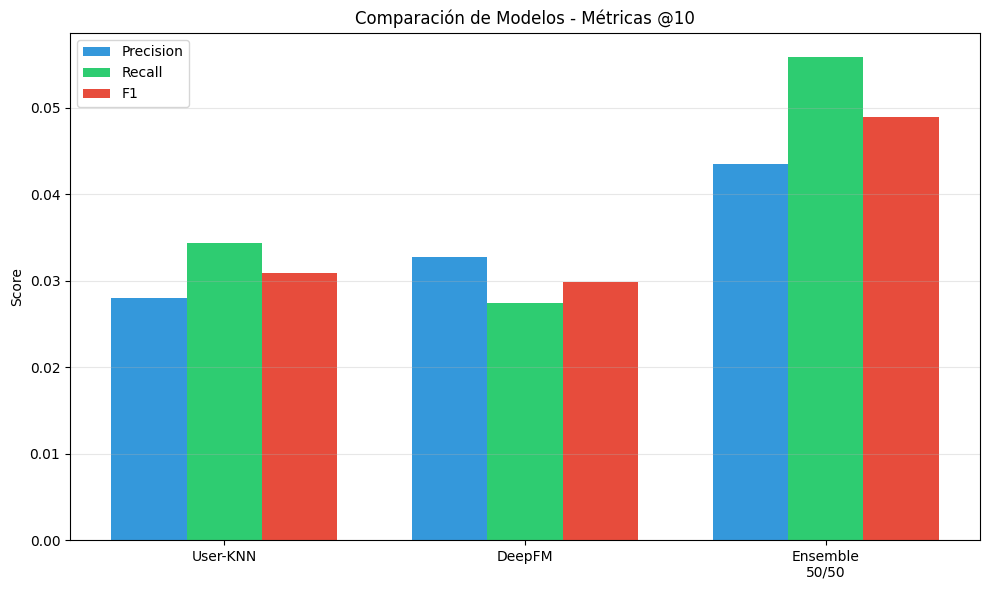

In [81]:
models = ['User-KNN', 'DeepFM', 'Ensemble\n50/50']
precision_vals = [0.0280, results_deepfm['precision'][10], best_results['precision'][10]]
recall_vals = [0.0343, results_deepfm['recall'][10], best_results['recall'][10]]
f1_vals = [0.0309, results_deepfm['f1'][10], best_results['f1'][10]]

x = np.arange(len(models))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, precision_vals, width, label='Precision', color='#3498db')
plt.bar(x, recall_vals, width, label='Recall', color='#2ecc71')
plt.bar(x + width, f1_vals, width, label='F1', color='#e74c3c')

plt.ylabel('Score')
plt.title('Comparación de Modelos - Métricas @10')
plt.xticks(x, models)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


# Evolución de F1 según K

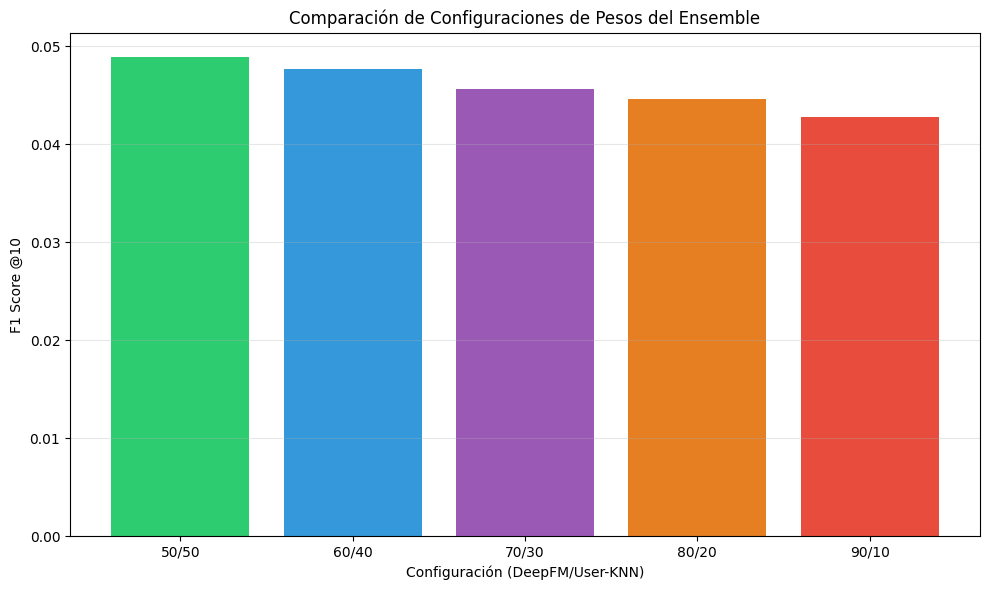

In [87]:
configs = ['50/50', '60/40', '70/30', '80/20', '90/10']
f1_configs = [0.0489, 0.0477, 0.0456, 0.0446, 0.0428]

plt.figure(figsize=(10, 6))
plt.bar(configs, f1_configs, color=['#2ecc71', '#3498db', '#9b59b6', '#e67e22', '#e74c3c'])
plt.xlabel('Configuración (DeepFM/User-KNN)')
plt.ylabel('F1 Score @10')
plt.title('Comparación de Configuraciones de Pesos del Ensemble')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


# Precision vs Recall vs Coverage @10

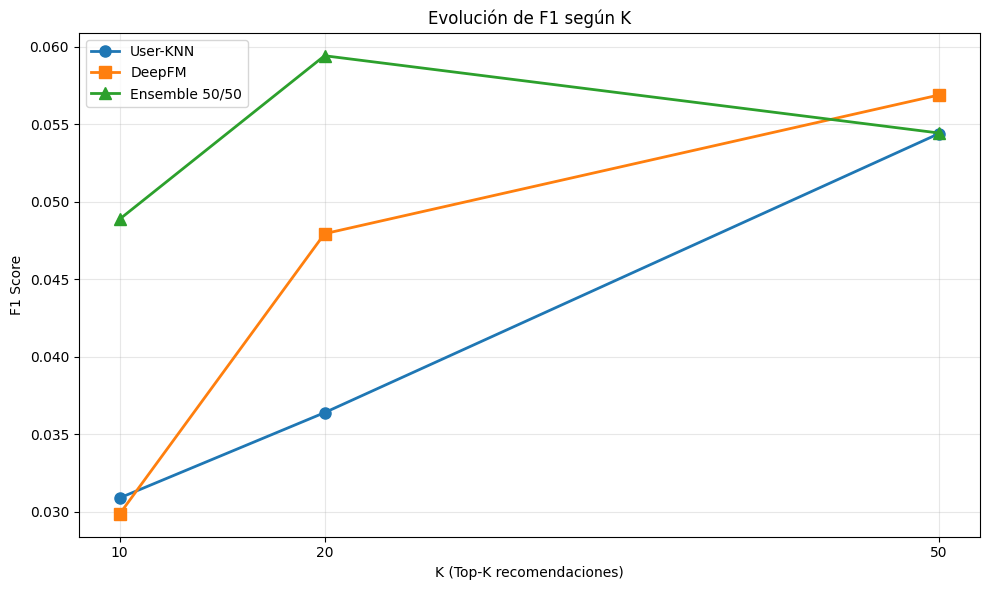

In [88]:
k_vals = [10, 20, 50]
uknn_f1 = [0.0309, 0.0364, 0.0544]
deepfm_f1 = [results_deepfm['f1'][k] for k in k_vals]
ensemble_f1 = [best_results['f1'][k] for k in k_vals]

plt.figure(figsize=(10, 6))
plt.plot(k_vals, uknn_f1, marker='o', linewidth=2, markersize=8, label='User-KNN')
plt.plot(k_vals, deepfm_f1, marker='s', linewidth=2, markersize=8, label='DeepFM')
plt.plot(k_vals, ensemble_f1, marker='^', linewidth=2, markersize=8, label='Ensemble 50/50')

plt.xlabel('K (Top-K recomendaciones)')
plt.ylabel('F1 Score')
plt.title('Evolución de F1 según K')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(k_vals)
plt.tight_layout()
plt.show()


# NDCG Comparativo @10, @20, @50

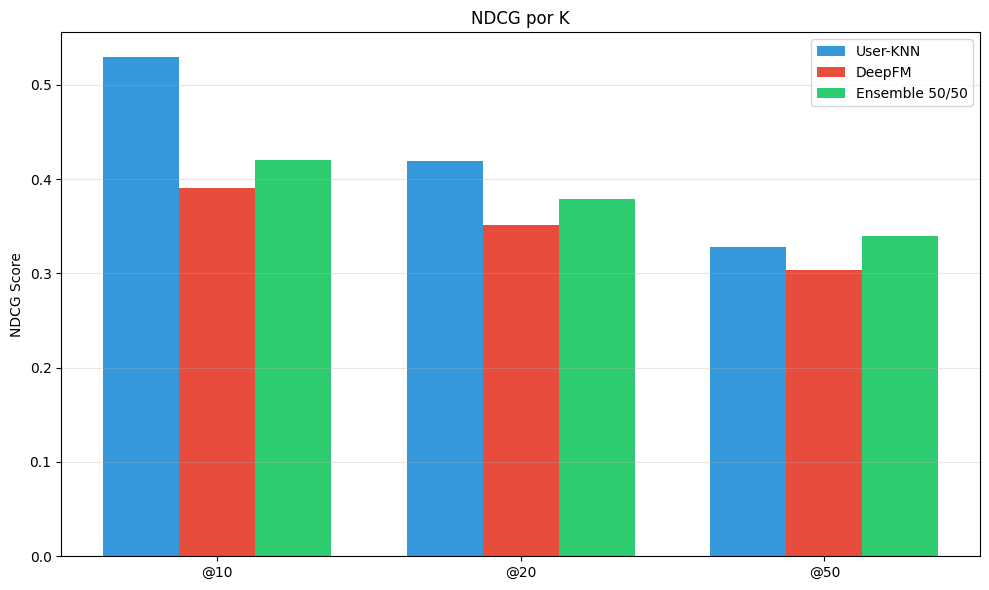

In [91]:
k_vals = [10, 20, 50]
uknn_ndcg = [0.5291, 0.4193, 0.3279]
deepfm_ndcg = [results_deepfm['ndcg'][k] for k in k_vals]
ensemble_ndcg = [best_results['ndcg'][k] for k in k_vals]

x = np.arange(len(k_vals))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, uknn_ndcg, width, label='User-KNN', color='#3498db')
plt.bar(x, deepfm_ndcg, width, label='DeepFM', color='#e74c3c')
plt.bar(x + width, ensemble_ndcg, width, label='Ensemble 50/50', color='#2ecc71')

plt.ylabel('NDCG Score')
plt.title('NDCG por K')
plt.xticks(x, ['@10', '@20', '@50'])
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
